In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:31<00:00,  1.64it/s]


In [3]:
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset_without_big = ThicknessDataset(PATH, mode=1, transform=augs)
thickness_dataset_only_big = ThicknessDataset(PATH, mode=2, transform=augs)
print("Number of samples in dataset without large object", len(thickness_dataset_without_big))
print("Number of samples in dataset with only large objects", len(thickness_dataset_only_big))

train_split = 0.9
valid_split = 0.1
train_size = int(train_split * len(thickness_dataset_without_big))+1
valid_size = int(valid_split * len(thickness_dataset_without_big))


train_dataset, valid_dataset = torch.utils.data.random_split(thickness_dataset_without_big, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

test_dataset = thickness_dataset_only_big

batch_size = 16 # 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=128)

Number of samples in dataset without large object 5514
Number of samples in dataset with only large objects 1038


In [18]:
path = "models\model_20230303-183712_164"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = U_Net()

criterion = nn.MSELoss()
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()
trained_model = model

Using cuda device


In [19]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans
from torchmetrics import PeakSignalNoiseRatio
full_loss = 0
fullstrsim = 0
full_mape = 0
batches = 0
mean_abs_percentage_error = PeakSignalNoiseRatio().to(device)

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)
        masked_loss = mse_loss_with_nans(outputs, labels)
        mape = mean_abs_percentage_error(outputs, labels)
        strsim = 0 
        for i in range(labels.cpu().numpy().shape[0]):
            strsim += ssim(outputs[i].cpu().numpy()[0], labels[i].cpu().numpy()[0])

        fullstrsim += strsim/labels.cpu().numpy().shape[0]
        full_mape += mape
        full_loss += masked_loss
        batches += 1
print("Test SSIM: {}".format(fullstrsim/batches))
print("Test loss: {}".format(full_loss/batches))
print("Test MAPE: {}".format(full_mape/batches))

Test SSIM: 0.9669089660787749
Test loss: 0.008251126855611801
Test MAPE: 28.09055519104004


In [20]:
with torch.no_grad():
    for data in test_dataloader:
        samples = data
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)
        break

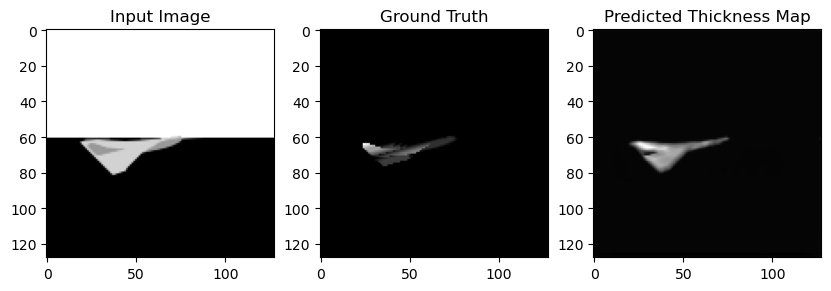

Structure Simililarity:  0.9820878650353372


In [21]:
# test visualisation/ qualitative evaluation
from skimage.metrics import structural_similarity as ssim
idx = 69
# sample = samples[idx]
output = outputs[idx]
with torch.no_grad():
    image, label = samples['img'][idx].to(device, dtype=torch.float), samples['thick_map'][idx].to(device, dtype=torch.float)
    image = image.cpu().numpy()
    label = label.cpu().numpy()
    output = output.cpu().numpy()

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1,3,2)
    plt.imshow(label[0], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.imshow(output[0], cmap='gray')
    plt.title('Predicted Thickness Map')
    plt.show()
print("Structure Simililarity: ",ssim(label[0], output[0].reshape(128,128)))
